In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

We first load the data 

In [2]:
data = pd.read_csv('D:/MachineLearning/music prediction/raw_data.csv', index_col = 0,header = 0)

We have a dataset of 10,000 songs and 31 associated features per song

In [3]:
data.head()

,analysis_sample_rate,danceability,duration,end_of_fade_in,energy,key,loudness,mode,start_of_fade_out,tempo,...,tag_top_2,tag_top_3,tag_top_4,tag_top_5,tag_top_6,tag_top_7,tag_top_8,tag_top_9,tag_top_10,year
0,22050,0.0,218.93179,0.247,0.0,1,-11.197,0,218.932,92.198,...,underground rap,g funk,alternative rap,gothic rock,west coast rap,rap,club dance,singer-songwriter,chill-out,0
1,22050,0.0,148.03546,0.148,0.0,6,-9.843,0,137.915,121.274,...,pop rock,blues-rock,beach music,soft rock,soul,classic rock,oldies,power pop,psychedelic rock,1969
2,22050,0.0,177.47546,0.282,0.0,8,-9.689,1,172.304,100.070,...,cumbia,tejano,ranchera,latin pop,latin,tropical,instrumental,christmas music,boleros,0
3,22050,0.0,233.40363,0.000,0.0,0,-9.013,1,217.124,119.293,...,new wave,dance rock,rock,new romantic,europop,beat,british pop,louisiana blues,gothic rock,1982
4,22050,0.0,209.60608,0.066,0.0,2,-4.501,1,198.699,129.738,...,ska punk,breakcore,alternative metal,punk pop,grunge,rock,punk,punk revival,grindcore,2007


We see that there are columns numerical (e.g. danceability, energy, duration) and columns categorical (e.g.artist location, artist name). Below is a preview of the dataset structure showing the data types and completeness of each feature

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   analysis_sample_rate  10000 non-null  int64  
 1   danceability          10000 non-null  float64
 2   duration              10000 non-null  float64
 3   end_of_fade_in        10000 non-null  float64
 4   energy                10000 non-null  float64
 5   key                   10000 non-null  int64  
 6   loudness              10000 non-null  float64
 7   mode                  10000 non-null  int64  
 8   start_of_fade_out     10000 non-null  float64
 9   tempo                 10000 non-null  float64
 10  time_signature        10000 non-null  int64  
 11  artist_familiarity    9996 non-null   float64
 12  artist_hotttnesss     10000 non-null  float64
 13  artist_latitude       3742 non-null   float64
 14  artist_location       10000 non-null  object 
 15  artist_longitude      374

# Split train and test sets

We split training and testing sets before conducting any analysis to ensure that the test set remains unseen during model development

In [5]:
train, test = train_test_split(data, test_size = 0.2, random_state=42)

# EDA

We began by exploring potential correlations among the numerical features to better understand the underlying patterns in the data

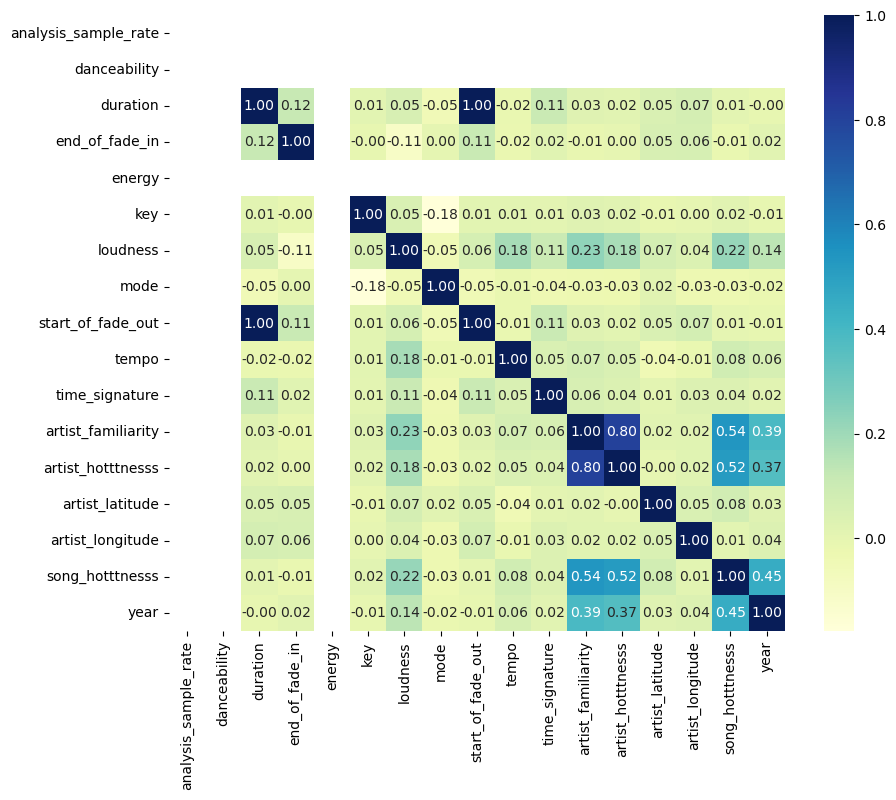

In [6]:
corr_mat = train.corr(numeric_only = True)

plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, annot=True, cmap = 'YlGnBu', fmt='.2f', square=True)
plt.show()

Notice that there are empty spaces at the rows and columns of 'analysis_sample_rate', 'danceability' and 'energy', this is bacause these features only contain a single unique value, making them uninformative. These columns were therefore dropped from the dataset.

In [7]:
print(train['danceability'].value_counts(),'\n'), print(train['analysis_sample_rate'].value_counts(),'\n'), 
print(train['energy'].value_counts())

danceability
0.0    8000
Name: count, dtype: int64 

analysis_sample_rate
22050    8000
Name: count, dtype: int64 

energy
0.0    8000
Name: count, dtype: int64


In [8]:
train = train.drop(["danceability", "analysis_sample_rate", "energy"], axis=1)

We also observed a strong collinearity between the pairs 'artist_familiarity' and 'artist_hotttnesss', as well as 'duration' and 'start_of_fade_out' in the pairwised plot. We took a closer look

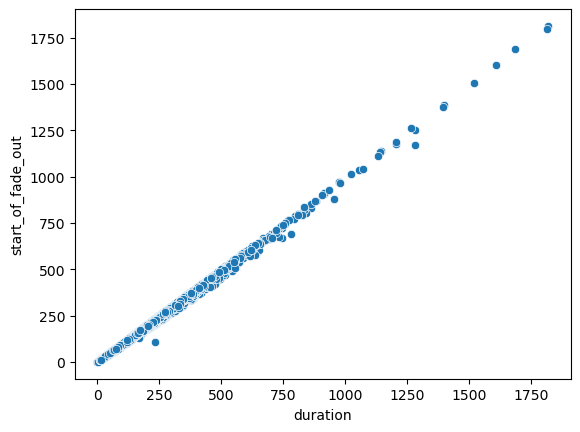

In [9]:
sns.scatterplot(data = train, x='duration', y='start_of_fade_out')
plt.show()

Almost a perfect straight line, we considered to remove the feature 'start_of_fade_out'. For the other pair

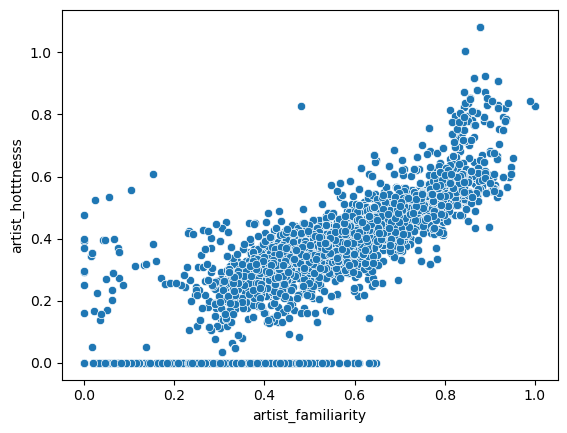

In [10]:
sns.scatterplot(data = train, x='artist_familiarity', y='artist_hotttnesss')
plt.show()

Also an obvious correlation between 'artist_familiarity' and 'artist_hottness' was observed, which aligns with our common sense: artists who are more familiar to the public tend to be more popular 

To settle down potential model fitting problems caused by multicollinearity, we dropped the 'start_of_fade_out' feature and applied a simple transformation into a single feature by averaging them (assuming equal weight):
$$
    \frac{(\mathrm{artist \ hottness} + \mathrm{artist \ familiarity})}{2}
$$

In [11]:
train = train.drop(["start_of_fade_out"], axis=1)
train['artist_hottness_combined'] = (train['artist_familiarity'] + train['artist_hotttnesss'])/2

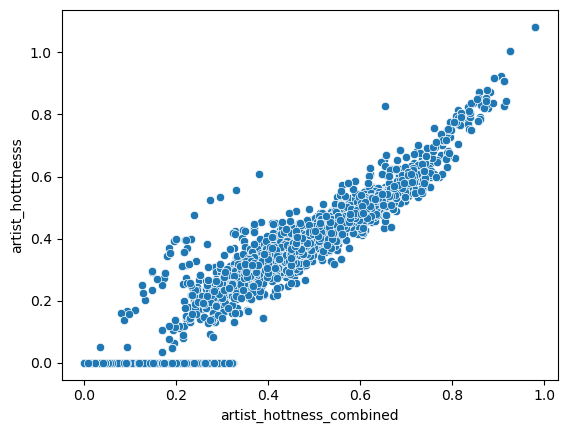

In [12]:
sns.scatterplot(x=train['artist_hottness_combined'], y=train['artist_hotttnesss'])
plt.show()

The correlation between 'song hottness' and the new combined feature seems to be well reserved, so we kept this combination.

In [13]:
train = train.drop(["artist_hotttnesss", "artist_familiarity"], axis=1)

We also explored the geo-locations of the artists, using color to highlight differences in their song hottness.

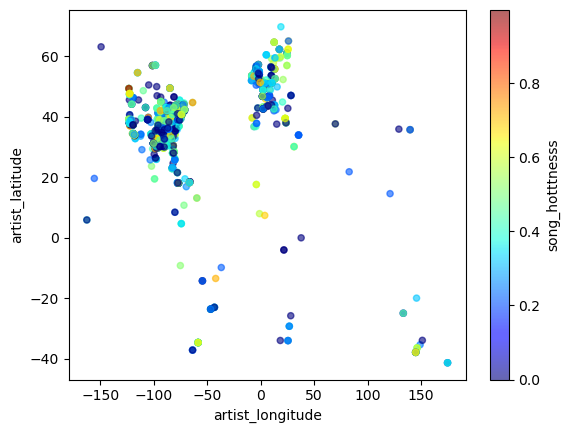

In [14]:
train.plot(kind = 'scatter', x='artist_longitude', y= 'artist_latitude',
          c="song_hotttnesss", cmap=plt.get_cmap("jet"), colorbar=True, alpha = 0.6)
plt.show()

From the plot, we observed that popular songs are more likely to be produced by artists located within certain geographic clusters.

Next, we explored possible data transformations to imporve model performance and ensure feature distributions are suitable for machie learning algorithms.

For numerical features, we examined whether any transformations could be applied to make their distributions more closely resemble a normal distribution.

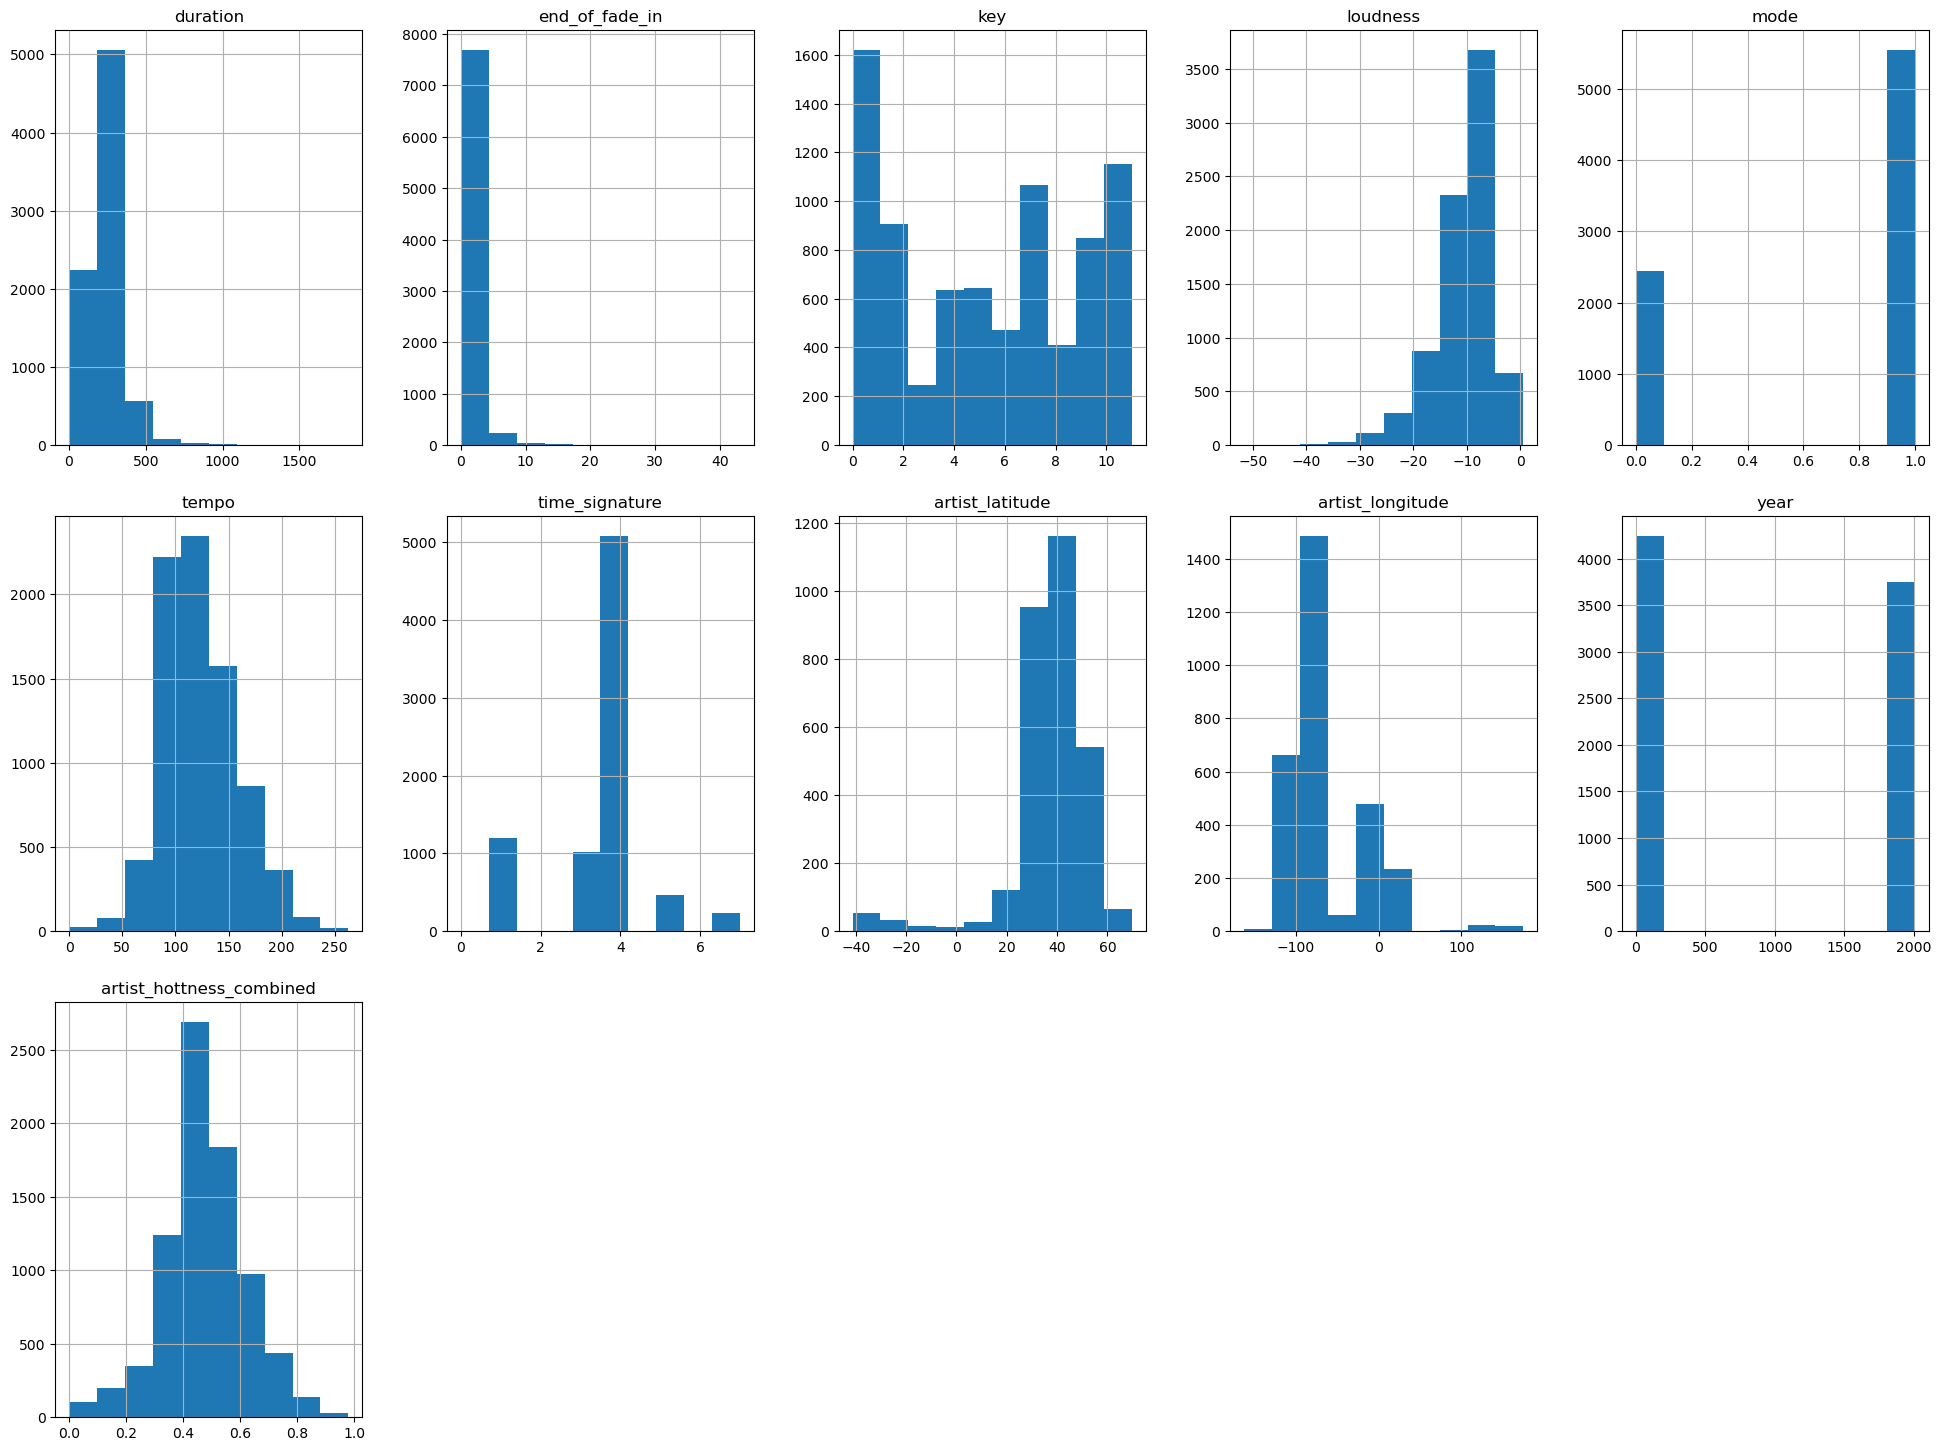

In [ ]:
column_names_numeric = train.select_dtypes(include= "number").columns.values
column_names_numeric = column_names_numeric[column_names_numeric != "song_hotttnesss"]

fig, axes = plt.subplots(3,5, figsize=(20,15))
fig.tight_layout(pad=3.0)
axes = axes.flatten()

for i, name in enumerate(column_names_numeric):
    train[name].hist(ax = axes[i])
    axes[i].set_title(name)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

We omit the detailed reasoning behind each transformation and instead present only the resulting distributions of the features

- duration: $x^{1/3}$
- end_of_fade_in: $x^{1/3}$
- loudness: $log(1 + abs(x))$
- tempo: $x$
- artist_latitude: $x$
- artist_longitude: $x$
- year: $x$
- artist_hottness_combined: $x$

In [16]:
train['duration'] = np.power(train['duration'], 1/3)
train['end_of_fade_in'] = np.power(train['end_of_fade_in'], 1/3)
train['loudness'] = np.log(1 + abs(train['loudness']))

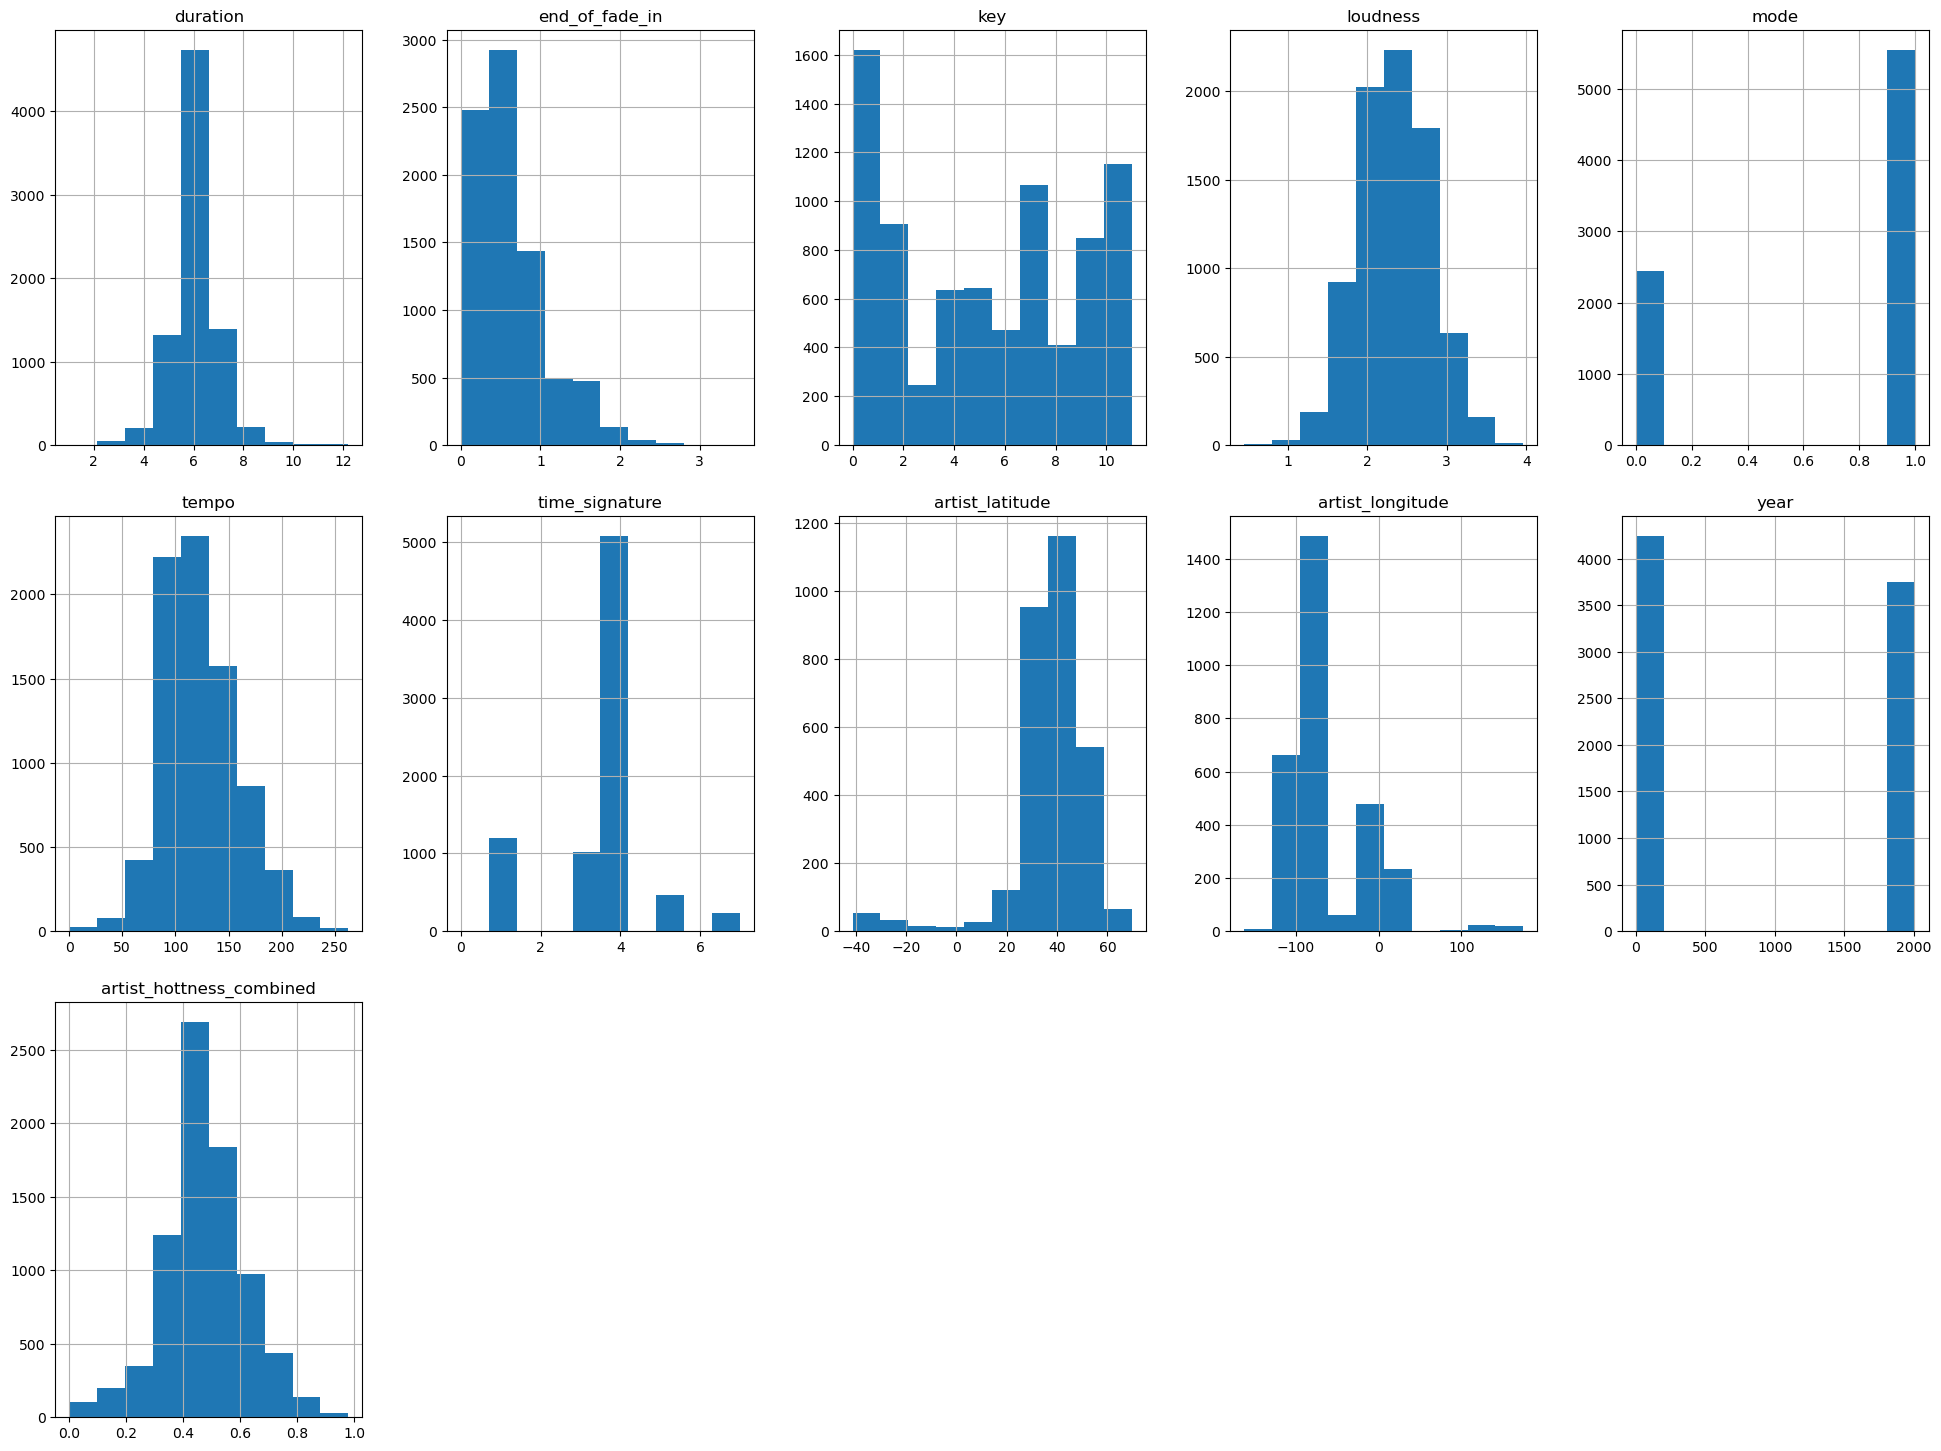

In [17]:
fig, axes = plt.subplots(3,5, figsize=(20,15))
fig.tight_layout(pad=3.0)
axes = axes.flatten()

for i, name in enumerate(column_names_numeric):
    train[name].hist(ax = axes[i])
    axes[i].set_title(name)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

The transformed features exhibit distributions that are closer to normal

Given the nature of musical features, we created interaction terms to capture potentially meaningful relationships:
- $\text{key} \times \text{mode}$
- $\text{tempo} \times \text{time signature}$

Additionally, we constructed a bag-of-words matrix, where each column represents one of the most frequent words extracted from each song's combined with its artist's top 10 bags

# Data preparation

## Na value

We checked the columns containing missing(NA) values

In [52]:
na_idx = train.isna().sum().index[np.where(train.isna().sum() != 0)]
train.isna().sum()[na_idx].rename("number of NA value")

tag_top_2      1
tag_top_3      1
tag_top_4      3
tag_top_5      3
tag_top_6      5
tag_top_7      7
tag_top_8     10
tag_top_9     14
tag_top_10    18
Name: number of NA value, dtype: int64

We did not impute the missing values for 'artist_latitude', 'artist_longitude' and 'song_hottnesss' using common strategies because they account for a large proportion of the data, which would likely distort the information and negatively impact model performance. Therefore, we dropped these columns

In [19]:
print("artist latitude na proportion:",5018 * 100/8000,"%")
print("artist longitude na proportion:", 3470 * 100/8000,"%")

artist latitude na proportion: 62.725 %
artist longitude na proportion: 43.375 %


In [20]:
train = train.drop(train[train['artist_latitude'].isna()].index)
train = train.drop(train[train['song_hotttnesss'].isna()].index)

We observed that a large proportion of songs have an unkonwn published year. According to the [feature description](http://millionsongdataset.com/pages/example-track-description/) of 'year', the published year of each songin the dataset is collected from MusicBrainz, where all information is contributed by community volunteers. Therefore, we interpret a year value of 0 as having certain implications - for example, some songs may not have been officially published and were only distributed within a small region. The difference between 0 and other year values could still capture a potential year-related effect on song hottness, even though it is not precisely measured. Based on this reasoning, we kept the rows where 'year' equals 0 

In [21]:
print("Number of songs that have published year 0:", sum(train['year'] == 0)) 
print("proportion:",sum(train['year'] == 0) * 100/train.shape[0])

Number of songs that have published year 0: 795
proportion: 45.11918274687855


Three additional features that are irrelevant to our model fitting will be dropped

In [22]:
train = train.drop(columns = ['genre','artist_name', 'artist_location','release'])

## Bag-of-words matrix

In [23]:
title_tag_string = train.columns.values[-13:-2]
title_tag_string

array(['title', 'tag_top_1', 'tag_top_2', 'tag_top_3', 'tag_top_4',
       'tag_top_5', 'tag_top_6', 'tag_top_7', 'tag_top_8', 'tag_top_9',
       'tag_top_10'], dtype=object)

We wrote reuseable functions to create the bag-of-words matrix

Function for combining each song's title with the top 10 tags of the artist who created it 

In [24]:
def combine_tags_title(df, title_tag_string):
    combine_series = df[title_tag_string[0]].fillna('').astype(str)
    for i in range(1, len(title_tag_string)):
        combine_series = combine_series + ' ' + df[title_tag_string[i]].fillna('').astype(str)

    return combine_series

In [25]:
sample_text = combine_tags_title(train, title_tag_string).head()
sample_text

1561    b'Bahama Lullaby' country blues piedmont blues...
5933    b"In Fate's Hands (Album Version)" screamo roc...
168     b'Robbers Kill Cop' electronica rock ambient a...
2588    b'Pickled Heads' instrumental rock flamenco ta...
6874    b'A Martyr For My Love For You' blues-rock gar...
dtype: object

We noticeed that the combined text data was not sufficiently clean, so additional cleaning was needed. We also implemented a function for text cleaning.

In [26]:
def string_cleaning(combined_text):
    combined_text = [text.lower() for text in combined_text]
    combined_text = [text[1:] for text in combined_text]
    combined_text = [re.sub(r"[^a-zA-Z\s]", "", text) for text in combined_text]

    return combined_text

In [27]:
string_cleaning(sample_text)

['bahama lullaby country blues piedmont blues delta blues ragtime chicago blues louisiana blues blues smooth jazz piano blues country rock',
 'in fates hands album version screamo rock alternative alternative rock emo pop acoustic metal pop emotional original',
 'robbers kill cop electronica rock ambient alternative club progressive house soundtrack techno electronic rap',
 'pickled heads instrumental rock flamenco tango soundtrack neoclassical sympho black metal rb opera downtempo goa',
 'a martyr for my love for you bluesrock garage rock blues alternative rock indie rock rock detroit indie alternative pop']

Now that the combined text is clean, we can proceed to build a pipeline for creating the bag-of-words matrix. Before that, we need to implement some custom transformers

In [28]:
class TextCleaningTransformer(BaseEstimator, TransformerMixin): # cleaning texts
    def fit(self,X, y=None):
        return self
    
    def transform(self, X, y = None):
        #column_names = X.columns.values
        column_names_text = X.columns.values[-13:-2]

        text_combined = combine_tags_title(X,column_names_text)
        text_combined = string_cleaning(text_combined)

        return text_combined

In [29]:
class Text_Token_transformer_df(BaseEstimator, TransformerMixin): # create bag-of-words matrix
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        vectorizer = CountVectorizer()
        X_matrix = vectorizer.fit_transform(X).toarray()

        X_df = pd.DataFrame(X_matrix)

        for word, index in vectorizer.vocabulary_.items():
            X_df = X_df.rename(columns={index: word})
        
        column_sum_X = X_df.sum(axis=0).values
        sorted_index_X = np.argsort(-column_sum_X)
        X_df = X_df.iloc[:,sorted_index_X]

        index_less_then_2 = np.where(X_df.sum(axis=0).values <3)[0][0]
        X_df = X_df.iloc[:,:index_less_then_2]
        
        return X_df
        

After all the relevant custom transformers were created, we built the pipeline for generating the bag-of-words matrix

In [30]:
Pipe_word_matrix_df = Pipeline([
    ('clean_text',TextCleaningTransformer()),
    ('text_token_to_df', Text_Token_transformer_df())
])

In [31]:
word_matrix = Pipe_word_matrix_df.fit_transform(train)

In [32]:
word_matrix.head()

,rock,pop,jazz,blues,metal,country,alternative,rap,soul,hop,...,que,al,ya,had,him,without,wo,simplicity,since,should
0,1,0,1,7,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2,0,0,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,1,0,1,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Categorical variable

For categorical variable encoding, we applied one-hot encoding to all categorical variables except for the interaction term $\text{tempo} \times \text{time signature}$. We first worte functions to perform this task, then implemented custom transformers to combine all columns from the one-hot encoded matrices and the bag-of-words matrix. Finally, we automated these operations by creating a pipeline.

In [33]:
def key_mode_interaction_encode(X): # 1. key one-h array 2.mode one-h array #3 key-mode interaction df
    key_encoder = OneHotEncoder()
    mode_encoder = OneHotEncoder()

    key_onehot = key_encoder.fit_transform(X[['key']])  
    mode_onehot = mode_encoder.fit_transform(X[['mode']]) 

    key_mode_interaction_matrix = np.einsum('ij,ik->ijk', key_onehot.toarray(), mode_onehot.toarray()).reshape(key_onehot.shape[0], -1)

    key_labels = key_encoder.categories_[0]
    mode_labels = mode_encoder.categories_[0]
    interaction_columns = [f'key_{k}_x_mode_{m}' for k in key_labels for m in mode_labels]
        
    return (key_onehot.toarray() , mode_onehot.toarray() , 
            pd.DataFrame(key_mode_interaction_matrix, columns=interaction_columns))

In [34]:
key_mode_interaction_encode(train)[0].shape

(1762, 12)

In [35]:
def timsig_tempo_interaction_encode(X):# 1. time signature one-h array #2. time-tempo interaction df
    timesig_encoder = OneHotEncoder()
    timesig_onehot = timesig_encoder.fit_transform(X[['time_signature']])
    
    tempo_timesig_interaction_matrix = X['tempo'].values.reshape(-1,1) * timesig_onehot.toarray()

    return timesig_onehot.toarray(), pd.DataFrame(tempo_timesig_interaction_matrix,
    columns=[f'tempo_x_timesig_{cat}' for cat in timesig_encoder.categories_[0]])

In [36]:
class combine_cat_columns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        key_cat_matrix = key_mode_interaction_encode(X)[0]
        mode_cat_matrix = key_mode_interaction_encode(X)[1]
        kry_mode_cat_interaction_matrix = key_mode_interaction_encode(X)[2].to_numpy()

        timesig_cat_matrix = timsig_tempo_interaction_encode(X)[0]
        #timesig_tempo_cat_interaction_matrix = timsig_tempo_interaction_encode(X)[1].to_numpy()

        return np.concat([key_cat_matrix, mode_cat_matrix, kry_mode_cat_interaction_matrix, timesig_cat_matrix],
                         axis = 1)


class combine_cat_word_columns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #word_matrix = word_matrix  #Pipe_word_matrix_df.fit_transform(train).to_numpy() 

        return np.concat([word_matrix, X], axis=1)

In [37]:
Pipe_cat = Pipeline([
    ('cat_columns', combine_cat_columns()),
    ('combine_word_cat_matrix', combine_cat_word_columns())
])

In [38]:
cat_columns = Pipe_cat.fit_transform(train)

In [39]:
print(cat_columns.shape)
cat_columns[:5, ]

(1762, 829)


array([[1., 0., 1., ..., 0., 0., 0.],
       [2., 2., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [4., 1., 0., ..., 1., 0., 0.]])

## Standardize

Then we standardized the numerical variables

In [41]:
train_numeric = train[['duration', 'end_of_fade_in','loudness','tempo','artist_latitude', 
                         'artist_longitude','year','artist_hottness_combined']]
train_numeric = np.concatenate([train_numeric.to_numpy(), timsig_tempo_interaction_encode(train)[1]], axis=1)

scaler = StandardScaler()
train_numeric = scaler.fit_transform(train_numeric)

We combined all columns except the target variable to obtain the final processed design matrix

In [42]:
matrix_list = [cat_columns, train_numeric]
def combine_all_columns(lst):
    return np.concatenate(lst, axis=1)

X_train = combine_all_columns(matrix_list)
y = train['song_hotttnesss']

In [43]:
X_train.shape

(1762, 842)

# Feature selection

Before fitting different ML models, we noticed that the ratio of instances to features was not large, which could easily lead to model overfitting. Therefore, we first conducted feature selection to remove potentially sparse features

In [58]:
X_train.shape[0] / X_train.shape[1]

2.0926365795724466

To achieve this, we applied LASSO and forward stepwise regression

## LASSO

We defined the alpha parameter space from $10^{-4}$ to $10$ and selected 50 values evenly spaced on a logarithmic scale. We then searched for the optimal alpha value through cross-validation

In [ ]:
lasso_cv = LassoCV(alphas=np.logspace(-4, 1, 50), cv=5) #start: 10^-4 end: 10^1
lasso_cv.fit(X_train, y)

LassoCV(alphas=array([1.00000000e-04, 1.26485522e-04, 1.59985872e-04, 2.02358965e-04,
       2.55954792e-04, 3.23745754e-04, 4.09491506e-04, 5.17947468e-04,
       6.55128557e-04, 8.28642773e-04, 1.04811313e-03, 1.32571137e-03,
       1.67683294e-03, 2.12095089e-03, 2.68269580e-03, 3.39322177e-03,
       4.29193426e-03, 5.42867544e-03, 6.86648845e-03, 8.68511374e-03,
       1.09854114e-02, 1.38949549e-0...
       2.81176870e-02, 3.55648031e-02, 4.49843267e-02, 5.68986603e-02,
       7.19685673e-02, 9.10298178e-02, 1.15139540e-01, 1.45634848e-01,
       1.84206997e-01, 2.32995181e-01, 2.94705170e-01, 3.72759372e-01,
       4.71486636e-01, 5.96362332e-01, 7.54312006e-01, 9.54095476e-01,
       1.20679264e+00, 1.52641797e+00, 1.93069773e+00, 2.44205309e+00,
       3.08884360e+00, 3.90693994e+00, 4.94171336e+00, 6.25055193e+00,
       7.90604321e+00, 1.00000000e+01]),
        cv=5)

In [45]:
lasso_cv.alpha_ # best alpha

np.float64(0.0010481131341546852)

In [46]:
lasso_reg = Lasso(alpha= 0.001)
lasso_reg.fit(X_train, y)

model = SelectFromModel(lasso_reg, prefit=True)
X_train_selected_lasso = model.transform(X_train)

The LASSO-selected features were reduced to 76

In [47]:
X_train_selected_lasso.shape

(1762, 76)

## Forward Step-Wise

By conducting forward step-wise regression, we selected 235 features, which is slightly more than those selected using LASSO regression

In [ ]:
sfs_reg = SequentialFeatureSelector(LinearRegression(), k_features=(1, 400) ,forward=True, scoring='neg_mean_squared_error',n_jobs=20, verbose=0)
sfs_reg = sfs_reg.fit(X_train, y)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=20)]: Done 260 tasks      | elapsed:    6.1s
[Parallel(n_jobs=20)]: Done 842 out of 842 | elapsed:    7.0s finished
Features: 1/400[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 802 out of 841 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=20)]: Done 841 out of 841 | elapsed:    1.4s finished
Features: 2/400[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 840 out of 840 | elapsed:    1.4s finished
Features: 3/400[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 c

In [49]:
len(sfs_reg.k_feature_names_)

235

In [62]:
subset_info = sfs_reg.subsets_

However, after visualizing both the cross-validation and training errors against the number of features, we observed that the model's cross-validation error started to gradually decrease around 170 features and began to increase around 240 features, indicating the sign of overfitting

In [101]:
feature_num_lis = []
cv_error_lis = []
training_error_lis = []

for i in range(400):
    cv_error_lis.append(abs(subset_info[i+1]["avg_score"]))
    feature_num_lis.append(i+1)

    X_train_progress = X_train[:,subset_info[i+1]["feature_idx"]]
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_progress, y)
    y_pred = lin_reg.predict(X_train_progress)
    training_error_lis.append(mean_squared_error(y, y_pred))

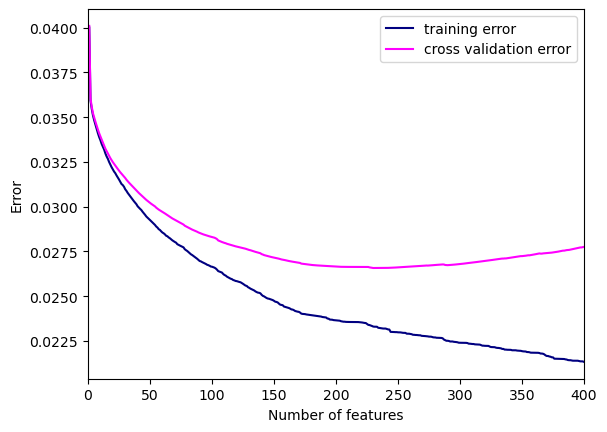

In [121]:
fig,ax = plt.subplots()
ax.plot(feature_num_lis, training_error_lis, label= "training error", color = "navy")
ax.plot(feature_num_lis, cv_error_lis, label = "cross validation error", color = "magenta")
ax.set(xlim=(0,400))
ax.set_ylabel("Error")
ax.set_xlabel("Number of features")
ax.legend()
plt.show()

Based on the zoom-in plot, we observed that the cross-validation error decreased slowly, indicating that increasing the number of features provided little improvement to model performance. So we decideed to set the number of selected forward stepwise features to 170

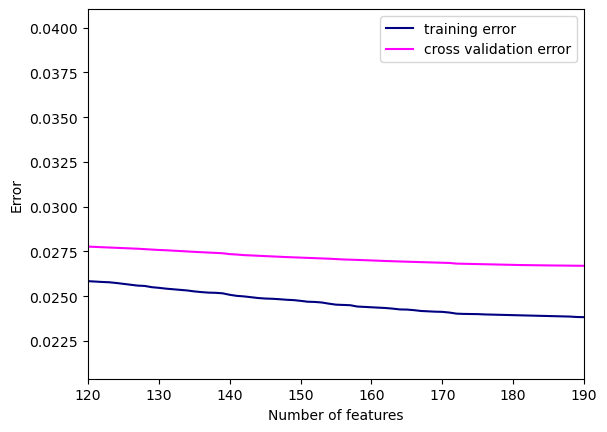

In [137]:
fig,ax = plt.subplots()
ax.plot(feature_num_lis, training_error_lis, label= "training error", color = "navy")
ax.plot(feature_num_lis, cv_error_lis, label = "cross validation error", color = "magenta")
ax.set(xlim=(120,190))
ax.set_ylabel("Error")
ax.set_xlabel("Number of features")
ax.legend()
plt.show()

After all the preparation work was completed, we started fitting all the candidates models

# Model Fitting

## Fitting with lasso selection matrix 

### Regression

#### Linear regression

In [ ]:
from sklearn.linear_model import SGDRegressor


In [ ]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train_selected_lasso, y)

In [ ]:
y_pred = sgd_reg.predict(X_train_selected_lasso)

In [ ]:
print("training MSE:",mean_squared_error(y, y_pred))

In [ ]:
print("SGD regression CV MSE:",
      np.abs(cross_val_score(sgd_reg, X_train_selected_lasso, y, cv=5,scoring="neg_mean_squared_error").mean())
      )

#### Kernel SVM regressor

In [ ]:
from sklearn.svm import SVR
rbf_svc_reg = SVR(kernel="rbf", C=0.1, gamma=1e-3)
rbf_svc_reg.fit(X_train_selected_lasso, y)

In [ ]:
print("RBF SVM regression CV MSE:",
      np.abs(cross_val_score(rbf_svc_reg, X_train_selected_lasso, y, cv=5,scoring="neg_mean_squared_error").mean())
      )

#### Random Froest regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfg = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2,
                      min_samples_leaf=1, max_features='sqrt')
rfg.fit(X_train_selected_lasso, y)

In [ ]:
print("Random froest regression CV MSE:",
      np.abs(cross_val_score(rfg, X_train_selected_lasso, y, cv=5,scoring="neg_mean_squared_error").mean())
      )

#### XG Boost regression

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, subsample=0.8)
xgb_reg.fit(X_train_selected_lasso, y)

In [ ]:
print("Random froest regression CV MSE:",
      np.abs(cross_val_score(xgb_reg, X_train_selected_lasso, y, cv=5,scoring="neg_mean_squared_error").mean())
      )

#### Light GBM regressor

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'subsample': 0.8,
    #'colsample_bytree': 0.8,
    'min_child_samples': 20,
    'n_estimators': 100
}

lgb_reg = LGBMRegressor()
#lgb_reg.fit(X_train_selected_lasso, y)

In [ ]:
print("Random froest regression CV MSE:",
      np.abs(cross_val_score(lgb_reg, X_train_selected_lasso, y, cv=5,scoring="neg_mean_squared_error").mean())
      )

In [ ]:
(y == 0).sum(), (data["song_hotttnesss"] == 0).sum()

### Classification

We also try classification

In [ ]:
(y >= 0.6).sum() / len(y)

Set 0.6 as the threhold

In [ ]:
y_label = y.copy()
y_label[y.iloc[np.where(y>= 0.6)].index] = 1
y_label[y.iloc[np.where(y< 0.6)].index] = 0

#### Logistice classification

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_classifer = SGDClassifier()
sgd_classifer.fit(X_train_selected_lasso, y_label)

In [ ]:
def multi_time_cv_scroe(times, clf,score_type):
    score_type = str(score_type)
    cv_sore_calculated = []
    for i in range(times):
        cv_sore_calculated.append(cross_val_score(clf, X_train_selected_lasso, y_label, cv=5, scoring=score_type).mean())
    
    return np.array(cv_sore_calculated).mean()

In [ ]:
print('cv accuracy:',multi_time_cv_scroe(10, sgd_classifer, "accuracy"))
print('cv precision:',multi_time_cv_scroe(10, sgd_classifer, "precision"))
print('cv recall:', multi_time_cv_scroe(10, sgd_classifer, "recall"))
print('cv F1 score:',multi_time_cv_scroe(10, sgd_classifer, "f1"))
print('cv AUC:',multi_time_cv_scroe(10, sgd_classifer, "roc_auc"))

#### RBF SVM Classification

In [ ]:
from sklearn.svm import SVC
rbf_svc_clf = SVC(kernel='rbf', gamma = 0.1, C= 10)
rbf_svc_clf.fit(X_train_selected_lasso, y_label)

print('cv accuracy:',multi_time_cv_scroe(10, rbf_svc_clf, "accuracy"))
print('cv precision:',multi_time_cv_scroe(10, rbf_svc_clf, "precision"))
print('cv recall:', multi_time_cv_scroe(10, rbf_svc_clf, "recall"))
print('cv F1 score:',multi_time_cv_scroe(10, rbf_svc_clf, "f1"))
print('cv AUC:',multi_time_cv_scroe(10, rbf_svc_clf, "roc_auc"))

#### Random Froest Classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rdf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2,
                      min_samples_leaf=1, max_features='sqrt')
rdf_clf.fit(X_train_selected_lasso, y_label)

print('cv accuracy:', multi_time_cv_scroe(10, rdf_clf, "accuracy"))
print('cv precision:', multi_time_cv_scroe(10, rdf_clf, "precision"))
print('cv recall:', multi_time_cv_scroe(10, rdf_clf, "recall"))
print('cv F1 score:',multi_time_cv_scroe(10, rdf_clf, "f1"))
print('cv AUC:',multi_time_cv_scroe(10, rdf_clf, "roc_auc"))

#### XG Boost classification

In [ ]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=None, subsample=0.8)
xgb_clf.fit(X_train_selected_lasso, y_label)

print('cv accuracy:', multi_time_cv_scroe(10, xgb_clf, "accuracy"))
print('cv precision:', multi_time_cv_scroe(10, xgb_clf, "precision"))
print('cv recall:', multi_time_cv_scroe(10, xgb_clf, "recall"))
print('cv F1 score:',multi_time_cv_scroe(10, xgb_clf, "f1"))
print('cv AUC:',multi_time_cv_scroe(10, xgb_clf, "roc_auc"))

#### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
gnb_clf.fit(X_train_selected_lasso, y_label)

In [ ]:
print('cv accuracy:', multi_time_cv_scroe(10, gnb_clf, "accuracy"))
print('cv precision:', multi_time_cv_scroe(10, gnb_clf, "precision"))
print('cv recall:', multi_time_cv_scroe(10, gnb_clf, "recall"))
print('cv F1 score:',multi_time_cv_scroe(10, gnb_clf, "f1"))
print('cv AUC:',multi_time_cv_scroe(10, gnb_clf, "roc_auc"))

#### Light GBM classification

In [ ]:
from lightgbm import LGBMClassifier
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

lgb_clf = LGBMClassifier(verbose = -1)

print('cv accuracy:', multi_time_cv_scroe(10, lgb_clf, "accuracy"))
print('cv precision:', multi_time_cv_scroe(10, lgb_clf, "precision"))
print('cv recall:', multi_time_cv_scroe(10, lgb_clf, "recall"))
print('cv F1 score:',multi_time_cv_scroe(10, lgb_clf, "f1"))
print('cv AUC:',multi_time_cv_scroe(10, lgb_clf, "roc_auc"))

## Fitting with foward-stepwise matrix

### Regression

#### Linear Regression

In [ ]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train_selected_stepwise, y)
print("SGD regression CV MSE:",
      np.abs(cross_val_score(sgd_reg, X_train_selected_stepwise, y, cv=5,scoring="neg_mean_squared_error").mean())
      )

#### RBF SVM Regression

In [ ]:
rbf_svc_reg = SVR(kernel="rbf", C=0.1, gamma=1e-3)
rbf_svc_reg.fit(X_train_selected_stepwise, y)
print("RBF SVM regression CV MSE:",
      np.abs(cross_val_score(rbf_svc_reg, X_train_selected_stepwise, y, cv=5,scoring="neg_mean_squared_error").mean())
      )

#### Random Forest regressor

In [ ]:
rfg = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2,
                      min_samples_leaf=1, max_features='sqrt')
rfg.fit(X_train_selected_stepwise, y)

print("Random froest regression CV MSE:",
      np.abs(cross_val_score(rfg, X_train_selected_stepwise, y, cv=5,scoring="neg_mean_squared_error").mean())
      )

#### XGBoost regressor

In [ ]:
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, subsample=0.8)
xgb_reg.fit(X_train_selected_stepwise, y)

print("Random froest regression CV MSE:",
      np.abs(cross_val_score(xgb_reg, X_train_selected_stepwise, y, cv=5,scoring="neg_mean_squared_error").mean())
      )

### Classification

#### Logistic regression

In [ ]:
def multi_time_cv_scroe_stepwise(times, clf,score_type):
    score_type = str(score_type)
    cv_sore_calculated = []
    for i in range(times):
        cv_sore_calculated.append(cross_val_score(clf, X_train_selected_stepwise, y_label, cv=5, scoring=score_type).mean())
    
    return np.array(cv_sore_calculated).mean()

In [ ]:
sgd_classifer = SGDClassifier()
sgd_classifer.fit(X_train_selected_stepwise, y_label)

print('cv accuracy:',multi_time_cv_scroe_stepwise(10, sgd_classifer, "accuracy"))
print('cv precision:',multi_time_cv_scroe_stepwise(10, sgd_classifer, "precision"))
print('cv recall:', multi_time_cv_scroe_stepwise(10, sgd_classifer, "recall"))
print('cv F1 score:',multi_time_cv_scroe_stepwise(10, sgd_classifer, "f1"))
print('cv AUC:',multi_time_cv_scroe_stepwise(10, sgd_classifer, "roc_auc"))

#### RBF SVM Classification

In [ ]:
rbf_svc_clf = SVC(kernel='rbf', gamma = 0.1, C= 10)
rbf_svc_clf.fit(X_train_selected_stepwise, y_label)

print('cv accuracy:',multi_time_cv_scroe_stepwise(10, rbf_svc_clf, "accuracy"))
print('cv precision:',multi_time_cv_scroe_stepwise(10, rbf_svc_clf, "precision"))
print('cv recall:', multi_time_cv_scroe_stepwise(10, rbf_svc_clf, "recall"))
print('cv F1 score:',multi_time_cv_scroe_stepwise(10, rbf_svc_clf, "f1"))
print('cv AUC:',multi_time_cv_scroe_stepwise(10, rbf_svc_clf, "roc_auc"))

#### Random Froest Classification

In [ ]:
rdf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2,
                      min_samples_leaf=1, max_features='sqrt')
rdf_clf.fit(X_train_selected_stepwise, y_label)

print('cv accuracy:', multi_time_cv_scroe_stepwise(10, rdf_clf, "accuracy"))
print('cv precision:', multi_time_cv_scroe_stepwise(10, rdf_clf, "precision"))
print('cv recall:', multi_time_cv_scroe_stepwise(10, rdf_clf, "recall"))
print('cv F1 score:',multi_time_cv_scroe_stepwise(10, rdf_clf, "f1"))
print('cv AUC:',multi_time_cv_scroe_stepwise(10, rdf_clf, "roc_auc"))

#### XGBoost Classification

In [ ]:
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=None, subsample=0.8)
xgb_clf.fit(X_train_selected_stepwise, y_label)

print('cv accuracy:', multi_time_cv_scroe_stepwise(10, xgb_clf, "accuracy"))
print('cv precision:', multi_time_cv_scroe_stepwise(10, xgb_clf, "precision"))
print('cv recall:', multi_time_cv_scroe_stepwise(10, xgb_clf, "recall"))
print('cv F1 score:',multi_time_cv_scroe_stepwise(10, xgb_clf, "f1"))
print('cv AUC:',multi_time_cv_scroe_stepwise(10, xgb_clf, "roc_auc"))

#### Naive Bayes Classifcation

In [ ]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_train_selected_stepwise, y_label)

print('cv accuracy:', multi_time_cv_scroe_stepwise(10, gnb_clf, "accuracy"))
print('cv precision:', multi_time_cv_scroe_stepwise(10, gnb_clf, "precision"))
print('cv recall:', multi_time_cv_scroe_stepwise(10, gnb_clf, "recall"))
print('cv F1 score:',multi_time_cv_scroe_stepwise(10, gnb_clf, "f1"))
print('cv AUC:',multi_time_cv_scroe_stepwise(10, gnb_clf, "roc_auc"))